# Named Entity Recognition using LSTM

The dataset is downloaded from : https://www.kaggle.com/namanj27/ner-dataset

#### Columns
* Word: This column contains English dictionary words form the sentence it is taken from.

* POS:
Parts of speech tag

* Tag:
Standard named entity recognition tags as follows

[
* ORGANIZATION - Georgia-Pacific Corp.,
*WHO PERSON - Eddy Bonte, President Obama
*LOCATION - Murray River, Mount Everest
*DATE - June, 2008-06-29
*TIME - two fifty a m, 1:30 p.m.
*MONEY - 175 million Canadian Dollars, GBP 10.40
*PERCENT - twenty pct, 18.75 %
*FACILITY - Washington Monument, Stonehenge
*GPE - South East Asia, Midlothian
]

### Work Flow:
* We will preprosses the data.
* We will create ids for each individual words and tags for all the sentences together.
* We will group words and tags by the sentences.
* We will pad each sentence with the max length of the length length of the largest sentence.
* We will make a LSTM model and train it to predict the test data.
* We will then evaluate the model.

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, TimeDistributed, Bidirectional, LSTM
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [3]:
tf.__version__

'2.7.0'

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/ner_datasetreference.csv',
                 encoding='unicode_escape', skipinitialspace=True)
df.head(30)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [5]:
df.columns

Index(['Sentence #', 'Word', 'POS', 'Tag'], dtype='object')

In [6]:
df.isnull().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


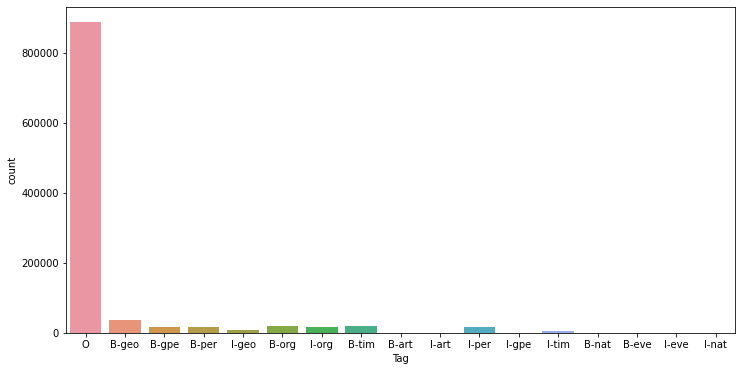

In [7]:
plt.figure(figsize=(12,6))
sns.countplot(df['Tag'])
plt.show()

# Date Preprocessing

In [8]:
df.ffill(axis=0, inplace=True)
df.head(30)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [9]:
df.isnull().sum()

Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

In [11]:
print("Number of unique words: ",len(list(set(df['Word'].to_list() ))) )

Number of unique words:  35178


In [12]:
print(list(set(df['Tag'].to_list())))
print("Number of unique tags: ", len(list(set(df['Tag'].to_list()))) )

['I-gpe', 'B-nat', 'I-per', 'B-per', 'B-geo', 'B-tim', 'I-eve', 'I-art', 'I-org', 'B-gpe', 'I-geo', 'B-org', 'I-tim', 'B-eve', 'I-nat', 'O', 'B-art']
Number of unique tags:  17


In [13]:
# Giving ids to each unque words and tags
def createIndex(data, col_name):
  corpus = []
  word2idx = {}
  idx2word = {}

  no_tokens = len(list(set(df['Word'].to_list())))    # Number of unique words
  no_tags = len(list(set(data['Tag'].to_list())))     # Number of unique tags

  if col_name == 'Word':
    corpus = list(set(data['Word'].to_list()))
  elif col_name == 'Tag':
    corpus = list(set(data['Tag'].to_list()))

  
  word2idx = {word: idx for idx, word in enumerate(corpus)}
  idx2word = {idx: word for idx, word in enumerate(corpus)}

  return word2idx, idx2word


word2idx, idx2word = createIndex(df, 'Word')
tag2idx, idx2tag = createIndex(df, 'Tag')

In [14]:
tag2idx

{'B-art': 16,
 'B-eve': 13,
 'B-geo': 4,
 'B-gpe': 9,
 'B-nat': 1,
 'B-org': 11,
 'B-per': 3,
 'B-tim': 5,
 'I-art': 7,
 'I-eve': 6,
 'I-geo': 10,
 'I-gpe': 0,
 'I-nat': 14,
 'I-org': 8,
 'I-per': 2,
 'I-tim': 12,
 'O': 15}

In [15]:
# Creating columns with word ids

df['Word_ids'] = df['Word'].map(word2idx)
df['Tag_ids'] = df['Tag'].map(tag2idx)

In [16]:
df.head(30)

,Sentence #,Word,POS,Tag,Word_ids,Tag_ids
0,Sentence: 1,Thousands,NNS,O,2176,15
1,Sentence: 1,of,IN,O,4505,15
2,Sentence: 1,demonstrators,NNS,O,30515,15
3,Sentence: 1,have,VBP,O,21911,15
4,Sentence: 1,marched,VBN,O,16497,15
5,Sentence: 1,through,IN,O,23695,15
6,Sentence: 1,London,NNP,B-geo,1164,4
7,Sentence: 1,to,TO,O,16797,15
8,Sentence: 1,protest,VB,O,16072,15
9,Sentence: 1,the,DT,O,17435,15


In [10]:
df.groupby(['Sentence #'], as_index=True)['Word', 'Tag'].agg(lambda x: list(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Word,Tag
Sentence #,,
Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo..."
Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,..."
Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O..."
Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[O, O, O, O, O, O, O, O, O, O, O]"
Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo..."
...,...,...
Sentence: 9995,"[Opposition, leader, Mir, Hossein, Mousavi, ha...","[O, O, O, B-per, I-per, O, O, O, O, O, O, O, O..."
Sentence: 9996,"[On, Thursday, ,, Iranian, state, media, publi...","[O, B-tim, O, B-gpe, O, O, O, O, O, O, O, O, B..."
Sentence: 9997,"[Following, Iran, 's, disputed, June, 12, elec...","[O, B-geo, O, O, B-tim, I-tim, O, O, O, O, O, ..."


In [17]:
# Grouping them to lists for each sentences
df_grouped = df.groupby(
    ['Sentence #'], as_index=True)['Word', 'Tag', 'Word_ids', 'Tag_ids'].agg(lambda x: list(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
df_grouped.head()

,Word,Tag,Word_ids,Tag_ids
Sentence #,,,,
Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[2176, 4505, 30515, 21911, 16497, 23695, 1164,...","[15, 15, 15, 15, 15, 15, 4, 15, 15, 15, 15, 15..."
Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[9357, 1112, 15397, 33777, 3197, 16797, 8727, ...","[9, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15..."
Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[25626, 4662, 34169, 14179, 31705, 31121, 2004...","[15, 15, 5, 15, 15, 15, 15, 15, 4, 15, 15, 15,..."
Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[O, O, O, O, O, O, O, O, O, O, O]","[28837, 19264, 19000, 32656, 6083, 19295, 2933...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]"
Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[24195, 18118, 12946, 18748, 892, 8378, 29429,...","[4, 15, 15, 3, 2, 15, 5, 15, 4, 15, 9, 15, 9, ..."


#  Padding word_ids and tag_ids

In [19]:
max([len(ids) for ids in df_grouped['Word_ids'].to_list()])

104

In [20]:
tags = df_grouped['Tag_ids'].to_list()
max([len(tag) for tag in tags])

104

In [21]:
def padding(data):

  # Number of words in largest statement
  statements = data['Word_ids'].to_list()
  max_len_statement = max([len(words) for words in statements])

  tags = data['Tag_ids'].to_list()
  max_len_tag = max([len(tag) for tag in tags])

  pad_statements = pad_sequences(sequences=statements, maxlen=max_len_statement,
                                   dtype='int32',padding='post', value=word2idx['The'])

  pad_tags = pad_sequences(sequences=tags, maxlen=max_len_tag,
                                  dtype='int32', padding='post', value=tag2idx['O']) 
  
  return pad_statements, pad_tags

In [22]:
pad_statements, pad_tags = padding(df_grouped)

In [23]:
print("Shape of pad_statements: ", pad_statements.shape)
print("\npad_statements:\n", pad_statements)
print("\nShape of pad_tags:\n", pad_tags.shape)
print("\npad_tags:\n", pad_tags)

Shape of pad_statements:  (47959, 104)

pad_statements:
 [[ 2176  4505 30515 ...  6858  6858  6858]
 [ 9357  1112 15397 ...  6858  6858  6858]
 [25626  4662 34169 ...  6858  6858  6858]
 ...
 [31099  9853 31281 ...  6858  6858  6858]
 [26967 29170 10057 ...  6858  6858  6858]
 [ 6858 26614  6802 ...  6858  6858  6858]]

Shape of pad_tags:
 (47959, 104)

pad_tags:
 [[15 15 15 ... 15 15 15]
 [ 9 15 15 ... 15 15 15]
 [15 15  5 ... 15 15 15]
 ...
 [15  4 15 ... 15 15 15]
 [15 15 15 ... 15 15 15]
 [15 11  8 ... 15 15 15]]


In [24]:
# Splitting into train test validation set
statements_, test_statements, tags_, test_tags = train_test_split(
    pad_statements, pad_tags, test_size=0.1, random_state=0
)

train_statements, val_statements, train_tags, val_tags = train_test_split(
    statements_, tags_, test_size=0.25, random_state=0
)
print("Shape of train_statements: ", train_statements.shape,
      "\nShape of train_tags: ", train_tags.shape,
      "\nShape of val_statements: ", val_statements.shape,
      "\nShape of val_tags: ", val_tags.shape,
      "\nShape of test_statements: ", test_statements.shape,
      "\nShape of test_tags: ", test_tags.shape,
      )

Shape of train_statements:  (32372, 104) 
Shape of train_tags:  (32372, 104) 
Shape of val_statements:  (10791, 104) 
Shape of val_tags:  (10791, 104) 
Shape of test_statements:  (4796, 104) 
Shape of test_tags:  (4796, 104)


In [25]:
input_dim = len(list(set(df['Word_ids'].to_list() ))) + 1
output_dim = 64
output_units = len(tag2idx)
input_len = max([len(s) for s in df_grouped['Word_ids'].to_list()])

print("input_dim: ", input_dim,
      "\noutput_dim: ", output_dim,
      "\noutput_units: ", output_units,
      "\ninput_len: ", input_len)

input_dim:  35179 
output_dim:  64 
output_units:  17 
input_len:  104


# Creating Model

In [26]:
# Create model
model = Sequential()
model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_len))
model.add(Bidirectional(LSTM(units=output_dim, dropout=0.2, recurrent_dropout=0.2, return_sequences=True), merge_mode='concat'))
model.add(LSTM(units=output_dim, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model.add(Dense(units=output_units, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 104, 64)           2251456   
                                                                 
 bidirectional (Bidirectiona  (None, 104, 128)         66048     
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 104, 64)           49408     
                                                                 
 dense (Dense)               (None, 104, 17)           1105      
                                                                 
Total params: 2,368,017
Trainable params: 2,368,017
Non-trainable params: 0
_________________________________________________________________


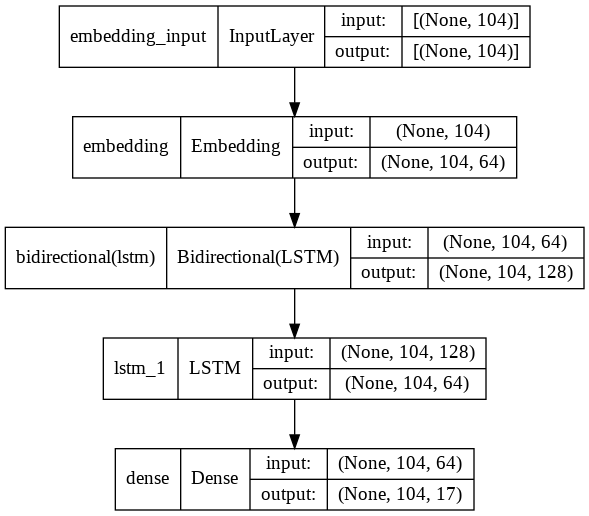

In [27]:
plot_model(model, show_shapes=True)

In [28]:
# compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
callback = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

In [30]:
hist = model.fit(train_statements, train_tags, batch_size=32, epochs=1,
                 validation_data=(val_statements, val_tags))

1012/1012 [==============================] - 555s 539ms/step - loss: 0.1288 - accuracy: 0.9726 - val_loss: 0.0574 - val_accuracy: 0.9831


# Validating Model

In [31]:
model.evaluate(x=val_statements, y=val_tags)

338/338 [==============================] - 22s 64ms/step - loss: 0.0574 - accuracy: 0.9831


[0.05735892802476883, 0.9831029176712036]

In [79]:
pred = model.predict(test_statements)

In [86]:
pred.shape, pred[0].shape

((4796, 104, 17), (104, 17))

In [98]:
pred[0]

array([[5.36526131e-05, 3.96619522e-04, 9.96315270e-04, ...,
        2.05490913e-04, 9.77778912e-01, 5.71630721e-04],
       [6.75001047e-07, 1.10404635e-05, 3.77008291e-05, ...,
        5.99112354e-06, 9.97998059e-01, 2.08528054e-05],
       [1.35016322e-07, 3.16911883e-06, 9.02972715e-06, ...,
        1.72879231e-06, 9.99323964e-01, 6.38187521e-06],
       ...,
       [2.64308806e-08, 1.21922676e-06, 1.52100608e-06, ...,
        5.83374060e-07, 9.99868035e-01, 1.78130153e-06],
       [2.67051643e-08, 1.24301232e-06, 1.49316327e-06, ...,
        5.88414764e-07, 9.99865532e-01, 1.79325230e-06],
       [2.70735434e-08, 1.26738280e-06, 1.47552612e-06, ...,
        5.94828975e-07, 9.99863148e-01, 1.80754182e-06]], dtype=float32)

In [99]:
np.argmax(pred[0], axis=-1)

array([15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        5, 15,  4, 10,  2, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15,  4, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15])

In [91]:
idx2word[1664]

'coup'

In [115]:
pred = model.predict(test_statements)
pred_tags = np.ravel(np.argmax(pred, axis=-1))

In [135]:
query = []
test_statements_words = [idx2word[wordidx] for wordidx in np.ravel(test_statements.tolist())]
query.append(test_statements_words[0:20])
print("query_text: ", ' '.join(query[0]))

ans_tags = []
test_tags_words = [idx2tag[idx] for idx in np.ravel(test_tags.tolist())]
ans_tags.append(test_tags_words[0:20])
print("Actual_tags: ", ans_tags)



ans_pred_tags = [idx2tag[id] for id in pred_tags[0:20]]
print("Predicted_tags: ", ans_pred_tags)

print()
print("--"*70)
print("  "*20+"A Better Representation "+" "*25)
print()

actual_tags = []
for i,j in zip(np.ravel(test_statements_words)[:20], np.ravel(test_tags_words)[:20]):
  actual_tags.append(i)
  actual_tags.append('['+j+'] ')

print("Actual tags   : ", ''.join(actual_tags))

predicted_tags = []
for i,j in zip(np.ravel(test_statements_words)[:20], ans_pred_tags):
  predicted_tags.append(i)
  predicted_tags.append('['+j+'] ')

print("predicted tags: ", ''.join(predicted_tags))



query_text:  Two federal policemen walk past crosses standing where eight women were found sexually assaulted and murdered in 2001 in Ciudad
Actual_tags:  [['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'B-geo']]
Predicted_tags:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'B-geo']

--------------------------------------------------------------------------------------------------------------------------------------------
                                        A Better Representation                          

Actual tags   :  Two[O] federal[O] policemen[O] walk[O] past[O] crosses[O] standing[O] where[O] eight[O] women[O] were[O] found[O] sexually[O] assaulted[O] and[O] murdered[O] in[O] 2001[B-tim] in[O] Ciudad[B-geo] 
predicted tags:  Two[O] federal[O] policemen[O] walk[O] past[O] crosses[O] standing[O] where[O] eight[O] women[O] were[O] found[O] sexually[O] assaulted[O] and[O

# Rough Work

In [133]:
actual_tags = []
for i,j in zip(np.ravel(test_statements_words)[:20], np.ravel(test_tags_words)[:20]):
  actual_tags.append(i)
  actual_tags.append('['+j+'] ')

print(''.join(actual_tags))

Two[O] federal[O] policemen[O] walk[O] past[O] crosses[O] standing[O] where[O] eight[O] women[O] were[O] found[O] sexually[O] assaulted[O] and[O] murdered[O] in[O] 2001[B-tim] in[O] Ciudad[B-geo] 


In [127]:
print(np.ravel(test_statements_words)[:20])
print(np.ravel(test_tags_words)[:20])

['Two' 'federal' 'policemen' 'walk' 'past' 'crosses' 'standing' 'where'
 'eight' 'women' 'were' 'found' 'sexually' 'assaulted' 'and' 'murdered'
 'in' '2001' 'in' 'Ciudad']
['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'B-tim' 'O' 'B-geo']


In [114]:
ans_pred_tags = [idx2tag[id] for id in np.ravel(pred_tags)[0:20]]
len(ans_pred_tags)

20

In [113]:
np.ravel(pred_tags).shape

(498784,)

In [ ]:
for wordidx in test_statements.tolist():
  print(wordidx)

In [ ]:
(test_statements.tolist())

In [64]:
np.ravel(test_tags.tolist())

array([15, 15, 15, ..., 15, 15, 15])

In [70]:
idx2tag[15]

'O'

## SpaCy Implementation

In [137]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
text = nlp('Two federal policemen walk past crosses standing where eight women were found sexually assaulted and murdered in 2001 in Ciudad')
displacy.render(text, style = 'ent', jupyter=True)